In [ ]:
# Imports
import scipy.io as sio
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

# Drive mount
from google.colab import drive
drive.mount('/content/drive')

%cd "drive/Shareddrives/DL_Project/"

# Data paths
image_path = "car_data/all_images/"
training_split = 0.8
validation_split = 0.1
# testing_split = 0.1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/Shareddrives/DL_Project/'
/content/drive/Shareddrives/DL_Project


In [ ]:
# Load DF
df = pd.read_excel("annotations.xlsx")

## Training regression model
Train regression model on extracted features of pre-trained YOLO, where YOLO is pre-trained on COCO (large general object detection dataset).

In [ ]:
# Load feature embeddings (that we created in YOLO_features_extraction notebook)
# features_save_path = "extracted_features/yolov8n_features.pkl"
features_save_path = "extracted_features/yolov8m_features.pkl"

with open(features_save_path, 'rb') as file:
  features_dict = unserialized_data = pickle.load(file)

# device = 'cuda:0'
device = torch.device("cuda" if torch.cuda.is_available() else"cpu")

batch_size = 2

In [ ]:
# Add feature embeddings to dataframes
def add_feature_embeddings_to_df(df):
  feature_embeddings = []

  for i, row in tqdm(df.iterrows(), total=len(df)):
    img_id = int(row['image_name'].split('.')[0])
    feature_embedding = features_dict[img_id].cpu()
    feature_embeddings.append(feature_embedding)

  df['feature_embedding'] = feature_embeddings
  return df

df_1 = add_feature_embeddings_to_df(df)

100%|██████████| 16185/16185 [00:01<00:00, 8665.45it/s]


In [ ]:
# Simple categorization
# Threshold where prices above it belong to the same categorie
top_threshold = 300000

# Number of bins below the top_threshold
num_categories = 16

# Categorie thresholds
categorie_thresholds = [(top_threshold/(num_categories-1))*i for i in range(1, num_categories)]

# Add price categoreies to dataframes
def add_price_categories_to_df(df, categorie_thresholds):
  categories = []
  num_categories = len(categorie_thresholds) + 1

  for i, row in tqdm(df.iterrows(), total=len(df)):
    price = int(row['price'])
    price_categorie = num_categories-1
    for j, threshold in enumerate(categorie_thresholds):
      if price < threshold:
        price_categorie = j
        break
    categories.append(price_categorie)

  df['category'] = categories
  return df

# Price balanced categories
# df_2 = add_price_categories_to_df(df_1, categorie_thresholds)
# num_categories = len(categorie_thresholds)+1

# Count balanced categories
df_2 = df_1
num_categories = 16
df_2['category'] = pd.qcut(df['price'], q=num_categories, labels=[i for i in range(num_categories)])
print(f'Number of categories: {num_categories}')

Number of categories: 16


In [ ]:
# Split
train_df, temp_df = train_test_split(df_2, train_size=training_split, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=validation_split/(1-training_split), stratify=temp_df['label'], random_state=42)

In [ ]:
# Create datasets + dataloaders
class CarDataset(Dataset):
  def __init__(self, df, device):
    self.X = [fe.to(device) for fe in df['feature_embedding'].values]
    # self.y = [torch.tensor(v, dtype=torch.float).to(device) for v in df['price'].values]
    # self.y = [torch.tensor(v, dtype=torch.long).to(device) for v in df['label'].values]
    self.y = [torch.tensor(v, dtype=torch.long).to(device) for v in df['category'].values]

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    feature_embedding = self.X[idx]
    label = self.y[idx]
    return feature_embedding, label

train_ds = CarDataset(train_df, device)
val_ds = CarDataset(val_df, device)
test_ds = CarDataset(test_df, device)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [ ]:
# Simple regression model
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(256, 512)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.layer3(x)
        return x

# Simple classification model
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.layer1 = nn.Linear(576, 1024)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(512, num_categories)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.layer3(x)
        return x

In [ ]:
# Training one epoch
def train_epoch(epoch, train_dl, loss_f):
  running_loss = 0.
  last_loss = 0.

  for i, data in enumerate(train_dl):
    inputs, labels = data

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_f(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      print('batch {} loss: {}'.format(i + 1, last_loss))
      running_loss = 0.

  return last_loss

In [ ]:
# Training
num_epochs = 50

# Regression
# lr = 0.05
# model = RegressionModel().to(device)
# loss_f = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Classification
lr = 0.01
momentum = 0.9
model = ClassificationModel().to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0
best_val_loss = 1_000_000.
train_losses, val_losses = [], []

for epoch in range(num_epochs):
  print('epoch {}:'.format(epoch_number + 1))
  model.train(True)
  avg_train_loss = train_epoch(epoch_number, train_dl, loss_f)

  running_val_loss = 0.0
  model.eval()

  # Disable torch grad + do validation
  with torch.no_grad():
    for i, vdata in enumerate(val_dl):
      val_inputs, val_labels = vdata
      val_outputs = model(val_inputs)
      val_loss = loss_f(val_outputs, val_labels)
      running_val_loss += val_loss

  avg_val_loss = running_val_loss / (i + 1)
  train_losses.append(float(avg_train_loss))
  val_losses.append(float(avg_val_loss))
  print('loss - train {} valid {}'.format(avg_train_loss, avg_val_loss))

  # Track best performance, and save the model's state
  if avg_val_loss < best_val_loss:
    best_vloss = avg_val_loss
    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(model.state_dict(), model_path)

  epoch_number += 1

epoch 1:
batch 1000 loss: 2.7547052068710327
batch 2000 loss: 2.69484132874012
batch 3000 loss: 2.665954270482063
batch 4000 loss: 2.664418562054634
batch 5000 loss: 2.6370555728673937
batch 6000 loss: 2.675365221500397
loss - train 2.675365221500397 valid 2.610095977783203
epoch 2:
batch 1000 loss: 2.6163074370622637
batch 2000 loss: 2.642103782236576
batch 3000 loss: 2.633274734377861
batch 4000 loss: 2.6174991236925127
batch 5000 loss: 2.633891352534294
batch 6000 loss: 2.620682924628258
loss - train 2.620682924628258 valid 2.580622434616089
epoch 3:
batch 1000 loss: 2.5970041785240174
batch 2000 loss: 2.599720221161842
batch 3000 loss: 2.620908371448517
batch 4000 loss: 2.59628074657917
batch 5000 loss: 2.596440998673439
batch 6000 loss: 2.631173072695732
loss - train 2.631173072695732 valid 2.583650827407837
epoch 4:
batch 1000 loss: 2.5738461188077926
batch 2000 loss: 2.572776681303978
batch 3000 loss: 2.59422401535511
batch 4000 loss: 2.5931998134851457
batch 5000 loss: 2.612394

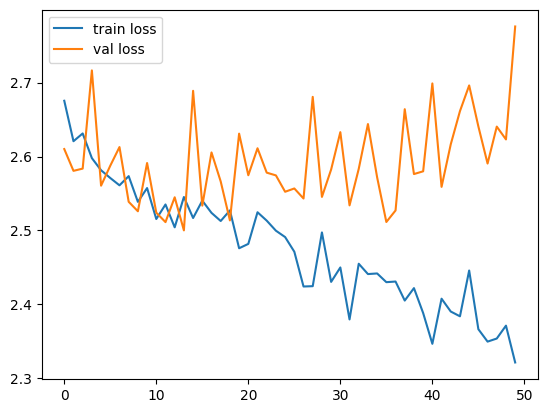

In [ ]:
# Plot loss
x = range(num_epochs)
plt.plot(x, train_losses, label = "train loss")
plt.plot(x, val_losses, label = "val loss")
plt.legend()
plt.show()

Accuracy: 0.18221124150710316


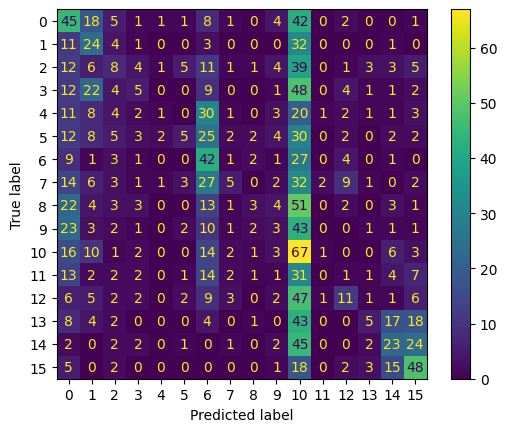

In [ ]:
# Test model
model.eval()
labels = []
preds = []

# Disable torch grad + do test
with torch.no_grad():
  for i, test_data in enumerate(test_dl):
    test_inputs, test_labels = test_data
    test_outputs = torch.argmax(model(test_inputs), 1)
    labels.append(test_labels)
    preds.append(test_outputs)

# Regression
# labels = [float(v) for v in torch.cat(labels, dim=0)]
# preds = [float(v) for v in torch.cat(preds, dim=0)]
# for l, p in zip(labels[:10], preds[:10]):
#   print(f'label = {l}, pred = {p}')

# Classification
labels = [int(v) for v in torch.cat(labels, dim=0)]
preds = [int(v) for v in torch.cat(preds, dim=0)]
cm = confusion_matrix(labels, preds)
accuracy = accuracy_score(labels, preds)
print(f"Accuracy: {accuracy}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()